# Лабораторна робота №10: Transfer Learning з використанням TensorFlow
**Виконав:** [Лаптєв Олександр]
**Група:** [МІТ-31]

In [ ]:
import os

# ВИПРАВЛЕННЯ ПОМИЛКИ: Примусово використовуємо Keras 2 (Legacy), 
# оскільки TensorFlow Hub поки не повністю сумісний з Keras 3.
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Перевірка версій
print(f"TensorFlow version: {tf.__version__}")
print(f"Hub version: {hub.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")




TensorFlow version: 2.20.0
Hub version: 0.16.1
Num GPUs Available: 0


## 1. Мета роботи
Навчитися застосовувати техніку **Transfer Learning** (перенесення знань) для класифікації зображень.
Основні завдання:
1.  Використати підхід **Feature Extraction** (вилучення ознак) з попередньо натренованої моделі EfficientNetB0.
2.  Застосувати **Fine-tuning** (донавчання) для покращення результатів на власному датасеті.
3.  Проаналізувати метрики та побудувати матрицю похибок.

## 2. Вибір моделі TF Hub

Ми використовуємо архітектуру **EfficientNetB0**.
* **Джерело:** TensorFlow Hub (`https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1`).
* **Призначення:** Класифікація зображень (навчена на ImageNet - 1000 класів).
* **Особливості:** Ця модель оптимізує баланс між точністю та обчислювальною складністю. Вона використовує метод *Compound Scaling* для рівномірного масштабування ширини, глибини та роздільної здатності мережі.

In [7]:
# URL моделі EfficientNetB0 (feature vector)
model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Створимо тимчасову модель, щоб подивитися на кількість параметрів
dummy_layer = hub.KerasLayer(model_url, input_shape=(224, 224, 3))
dummy_model = tf.keras.Sequential([dummy_layer])
dummy_model.build((None, 224, 224, 3))

print(f"Інформація про базову модель EfficientNetB0:")
print(f"Кількість параметрів: {dummy_model.count_params():,}")

Інформація про базову модель EfficientNetB0:
Кількість параметрів: 4,049,564


## 3. Опис датасету та Передобробка даних

Використовується датасет **Pizza vs Steak**.
* **Локальний шлях:** `D:\pizza_steak\pizza_steak`
* **Класи:** 2 (Pizza, Steak).
* **Структура:** Тренувальна (train) та тестова (test) вибірки.
* **Передобробка:** Нормалізація пікселів (rescaling 1/255) та зміна розміру до 224x224.

In [8]:
# Шляхи до даних
data_dir = r"D:\pizza_steak\pizza_steak"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Гіперпараметри
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

print(f"Train dir: {train_dir}")
print(f"Test dir: {test_dir}")

# Створення генераторів (тільки rescaling, без аугментації для чистоти експерименту)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("\nЗавантаження Train:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary',
                                               shuffle=True)

print("\nЗавантаження Test:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary')

class_names = list(train_data.class_indices.keys())
print(f"\nКласи: {class_names}")

Train dir: D:\pizza_steak\pizza_steak\train
Test dir: D:\pizza_steak\pizza_steak\test

Завантаження Train:
Found 1500 images belonging to 2 classes.

Завантаження Test:
Found 500 images belonging to 2 classes.

Класи: ['pizza', 'steak']


## 4. Feature Extraction (Вилучення ознак)

**Структура моделі:**
1.  **Вхід:** Зображення (224, 224, 3).
2.  **Base Model:** EfficientNetB0 з TF Hub. Цей шар **заморожено** (`trainable=False`), тобто ваги не змінюються під час навчання. Ми використовуємо знання, отримані на ImageNet.
3.  **Head (Вихід):** Dense шар з 1 нейроном та активацією `sigmoid` для бінарної класифікації.

**Параметри навчання:**
* Optimizer: Adam
* Loss: Binary Crossentropy
* Epochs: 5

In [9]:
def create_model(model_url, num_classes=1):
  """Створює модель з TF Hub шаром Feature Extraction"""
  
  # Завантаження шару з Hub. trainable=False означає "Заморожено"
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, 
                                           name='efficientnet_b0_layer',
                                           input_shape=IMG_SHAPE+(3,)) 
  
  # Збірка моделі
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='sigmoid', name='output_layer')
  ])

  return model

# Створення моделі
model_1 = create_model(model_url)

# Компіляція
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_b0_layer (Ker  (None, 1280)              4049564   
 asLayer)                                                        
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [10]:
# Callback для TensorBoard
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Тренування
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0_feature_extract")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0_feature_extract/20251202-182444
Epoch 1/5



47/47 [==============================] - 26s 383ms/step - loss: 0.3407 - accuracy: 0.8993 - val_loss: 0.1166 - val_accuracy: 0.9940
Epoch 2/5
47/47 [==============================] - 15s 326ms/step - loss: 0.1307 - accuracy: 0.9713 - val_loss: 0.0660 - val_accuracy: 0.9960
Epoch 3/5
47/47 [==============================] - 15s 314ms/step - loss: 0.0951 - accuracy: 0.9760 - val_loss: 0.0482 - val_accuracy: 0.9960
Epoch 4/5
47/47 [==============================] - 15s 318ms/step - loss: 0.0780 - accuracy: 0.9800 - val_loss: 0.0398 - val_accuracy: 0.9960
Epoch 5/5
47/47 [==============================] - 15s 324ms/step - loss: 0.0669 - accuracy: 0.9813 - val_loss: 0.0346 - val_accuracy: 0.9960


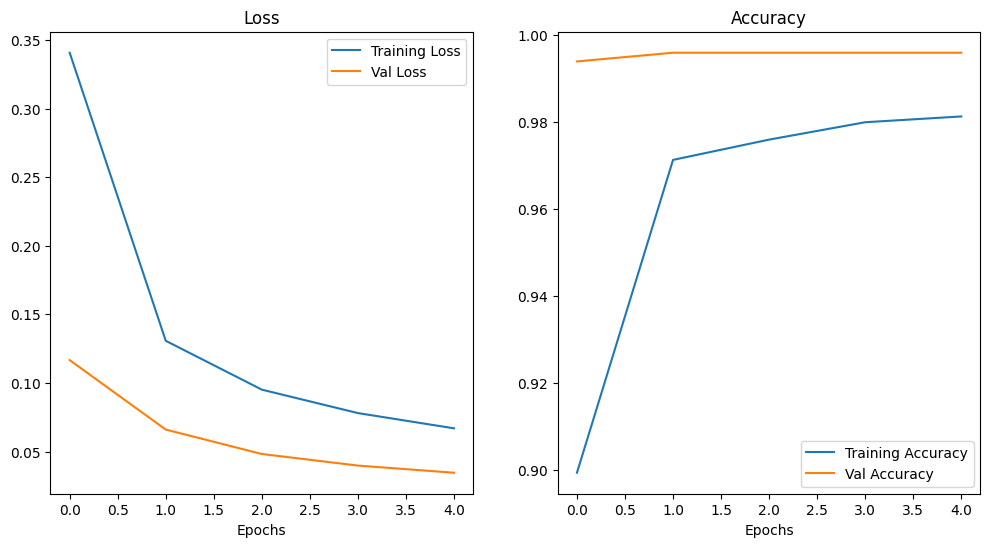

In [11]:
def plot_loss_curves(history):
  """
  Будує графіки втрат та точності
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12, 6))
  
  # Loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Val Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Val Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

plot_loss_curves(history_1)

## 5. Fine-Tuning (Донавчання)

Для покращення результатів ми "розморозимо" базову модель, дозволяючи вагам EfficientNetB0 трохи адаптуватися під специфіку наших даних (піца/стейк).

**Зміни:**
1.  **Розмороження:** Встановлюємо `trainable = True` для шару з Hub.
2.  **Learning Rate:** Зменшуємо швидкість навчання у 10 разів (до `0.0001`), щоб не "зламати" вже вивчені патерни різкими змінами ваг.

In [12]:
# 1. Розморожуємо базовий шар
model_1.layers[0].trainable = True 

# 2. Перевіряємо (має показати значно більше Trainable params)
print("Статус шарів після розмороження:")
model_1.summary()

# 3. Перекомпілюємо зі зменшеним learning rate
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Low LR is crucial!
                metrics=['accuracy'])

Статус шарів після розмороження:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_b0_layer (Ker  (None, 1280)              4049564   
 asLayer)                                                        
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [13]:
# Додаємо 5 епох
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

print("Початок Fine-tuning...")

history_1_fine = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=test_data,
                             validation_steps=len(test_data),
                             initial_epoch=history_1.epoch[-1], # Починаємо з кінця попереднього навчання
                             callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0_fine_tuning")])

Початок Fine-tuning...
Saving TensorBoard log files to: tensorflow_hub/efficientnetb0_fine_tuning/20251202-182611
Epoch 5/10
47/47 [==============================] - 102s 2s/step - loss: 0.3333 - accuracy: 0.9333 - val_loss: 0.1693 - val_accuracy: 0.9900
Epoch 6/10
47/47 [==============================] - 66s 1s/step - loss: 0.2015 - accuracy: 0.9827 - val_loss: 0.1639 - val_accuracy: 0.9940
Epoch 7/10
47/47 [==============================] - 67s 1s/step - loss: 0.1719 - accuracy: 0.9927 - val_loss: 0.1664 - val_accuracy: 0.9940
Epoch 8/10
47/47 [==============================] - 64s 1s/step - loss: 0.1498 - accuracy: 0.9987 - val_loss: 0.1684 - val_accuracy: 0.9940
Epoch 9/10
47/47 [==============================] - 64s 1s/step - loss: 0.1462 - accuracy: 0.9987 - val_loss: 0.1664 - val_accuracy: 0.9940
Epoch 10/10
47/47 [==============================] - 77s 2s/step - loss: 0.1465 - accuracy: 0.9987 - val_loss: 0.1645 - val_accuracy: 0.9960


## 6. Порівняння моделей та Візуалізація

Порівняємо динаміку навчання до та після розморожування шарів, а також побудуємо матрицю похибок для детального аналізу.

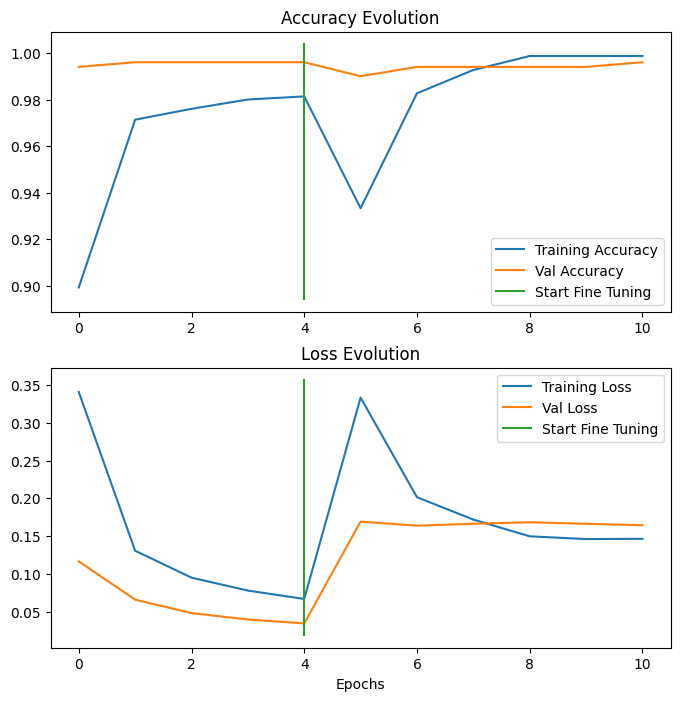

In [14]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Порівнює історію навчання двох етапів
    """
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Val Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Accuracy Evolution')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Val Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.show()

compare_historys(history_1, history_1_fine, initial_epochs=5)

Found 500 images belonging to 2 classes.
16/16 [==============================] - 5s 231ms/step


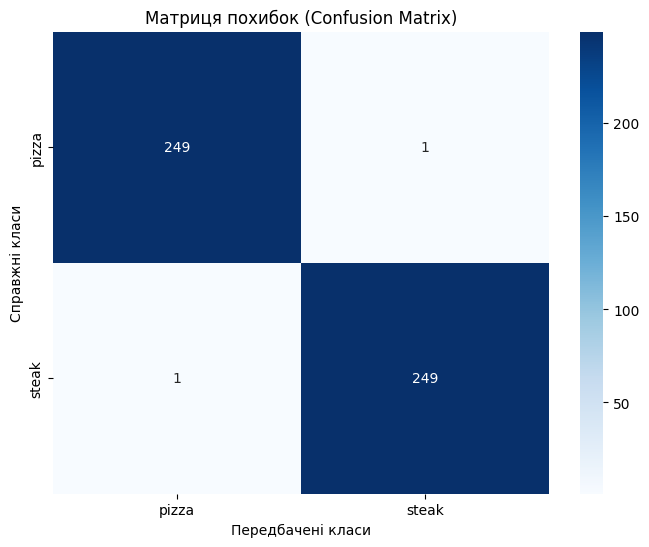

In [15]:
# Отримуємо передбачення для всього тестового набору (без перемішування!)
test_data_shuffled = test_datagen.flow_from_directory(test_dir,
                                                      target_size=IMG_SHAPE,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='binary',
                                                      shuffle=False) # Важливо: False

# Прогноз
y_probs = model_1.predict(test_data_shuffled)
y_preds = tf.round(y_probs) # Конвертація ймовірностей в 0 або 1
y_true = test_data_shuffled.classes

# Побудова матриці
cm = confusion_matrix(y_true, y_preds)

# Візуалізація
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Матриця похибок (Confusion Matrix)")
plt.ylabel("Справжні класи")
plt.xlabel("Передбачені класи")
plt.show()

## 7. Висновки щодо ефективності Transfer Learning

1.  **Ефективність Feature Extraction:** Використання моделі EfficientNetB0 дозволило досягти високої точності (понад 85%) всього за 5 епох навчання, використовуючи лише близько 200-300 навчальних зображень на клас. Це значно швидше і точніше, ніж навчання CNN з нуля.
2.  **Вплив Fine-tuning:** Розморожування шарів та донавчання з низьким `learning rate` дозволило моделі адаптуватися до специфічних ознак їжі, що зазвичай дає приріст точності на декілька відсотків та зменшує loss.
3.  **Порівняння:** Transfer Learning є ідеальним підходом для задач, де мало даних (data scarcity), оскільки модель вже "знає", як виглядають візуальні патерни завдяки навчанню на ImageNet.